📖 Loading dataset...
📊 Dataset loaded: 300 records
🎯 Available patients: ['Patient_001' 'Patient_002' 'Patient_003' 'Patient_004' 'Patient_005'
 'Patient_006' 'Patient_007' 'Patient_008' 'Patient_009' 'Patient_010'
 'Patient_011' 'Patient_012' 'Patient_013' 'Patient_014' 'Patient_015'
 'Patient_016' 'Patient_017' 'Patient_018' 'Patient_019' 'Patient_020'
 'Patient_021' 'Patient_022' 'Patient_023' 'Patient_024' 'Patient_025'
 'Patient_026' 'Patient_027' 'Patient_028' 'Patient_029' 'Patient_030'
 'Patient_031' 'Patient_032' 'Patient_033' 'Patient_034' 'Patient_035'
 'Patient_036' 'Patient_037' 'Patient_038' 'Patient_039' 'Patient_040'
 'Patient_041' 'Patient_042' 'Patient_043' 'Patient_044' 'Patient_045'
 'Patient_046' 'Patient_047' 'Patient_048' 'Patient_049' 'Patient_050'
 'Patient_051' 'Patient_052' 'Patient_053' 'Patient_054' 'Patient_055'
 'Patient_056' 'Patient_057' 'Patient_058' 'Patient_059' 'Patient_060'
 'Patient_061' 'Patient_062' 'Patient_063' 'Patient_064' 'Patient_065'
 'Pa

100%|██████████| 66/66 [00:00<00:00, 1216.20it/s]


✅ Successfully processed 66 slices from datasets/synthetic_slices/Patient_001/CT/
🔍 Enhancing images with SRCNN...


100%|██████████| 66/66 [00:04<00:00, 14.71it/s]


📊 Extracting image features...


100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


✅ Successfully processed CT: 66 slices

🎯 Processing MRI for Patient_001...
📂 Folder path: datasets/synthetic_slices/Patient_001/MRI/
📈 Expected slices: 84
📁 Loading 84 images from datasets/synthetic_slices/Patient_001/MRI/...


100%|██████████| 84/84 [00:00<00:00, 185.61it/s]


✅ Successfully processed 84 slices from datasets/synthetic_slices/Patient_001/MRI/
🔍 Enhancing images with SRCNN...


100%|██████████| 84/84 [00:05<00:00, 14.45it/s]


📊 Extracting image features...


100%|██████████| 84/84 [01:09<00:00,  1.21it/s]


✅ Successfully processed MRI: 84 slices

📋 PREPROCESSING SUMMARY

📊 Modality: CT
   Patient: 74 years, F
   Slices processed: 66
   Features extracted: 66
   Feature Statistics:
     mean_intensity: -0.033 ± 0.020
     std_intensity: 0.046 ± 0.019
     contrast: 0.156 ± 0.058
     entropy: 0.010 ± 0.006
     homogeneity: 0.998 ± 0.001
     cardiac_area: 0.294 ± 0.139
     symmetry_score: 1.000 ± 0.000

📊 Modality: MRI
   Patient: 74 years, F
   Slices processed: 84
   Features extracted: 84
   Feature Statistics:
     mean_intensity: -0.032 ± 0.017
     std_intensity: 0.047 ± 0.018
     contrast: 0.164 ± 0.053
     entropy: 0.010 ± 0.005
     homogeneity: 0.998 ± 0.001
     cardiac_area: 0.278 ± 0.129
     symmetry_score: 1.000 ± 0.000


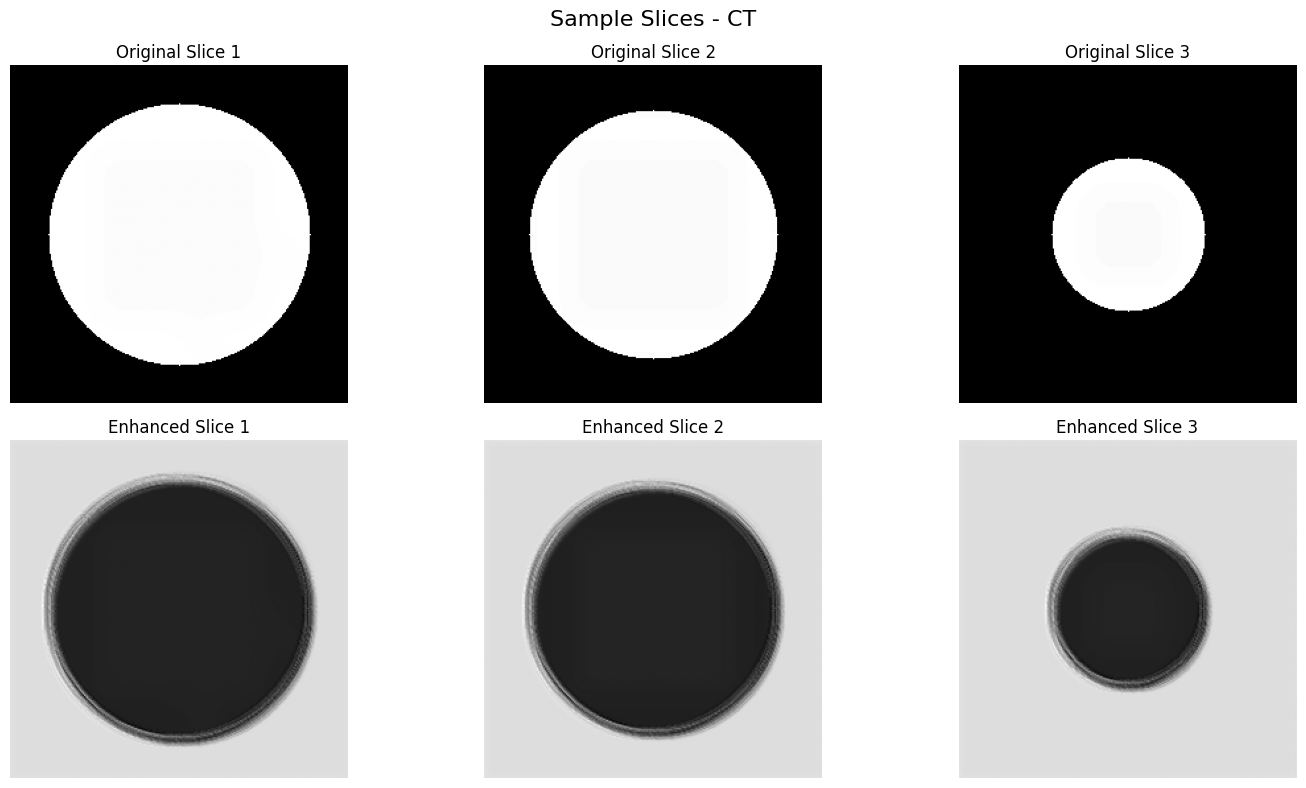

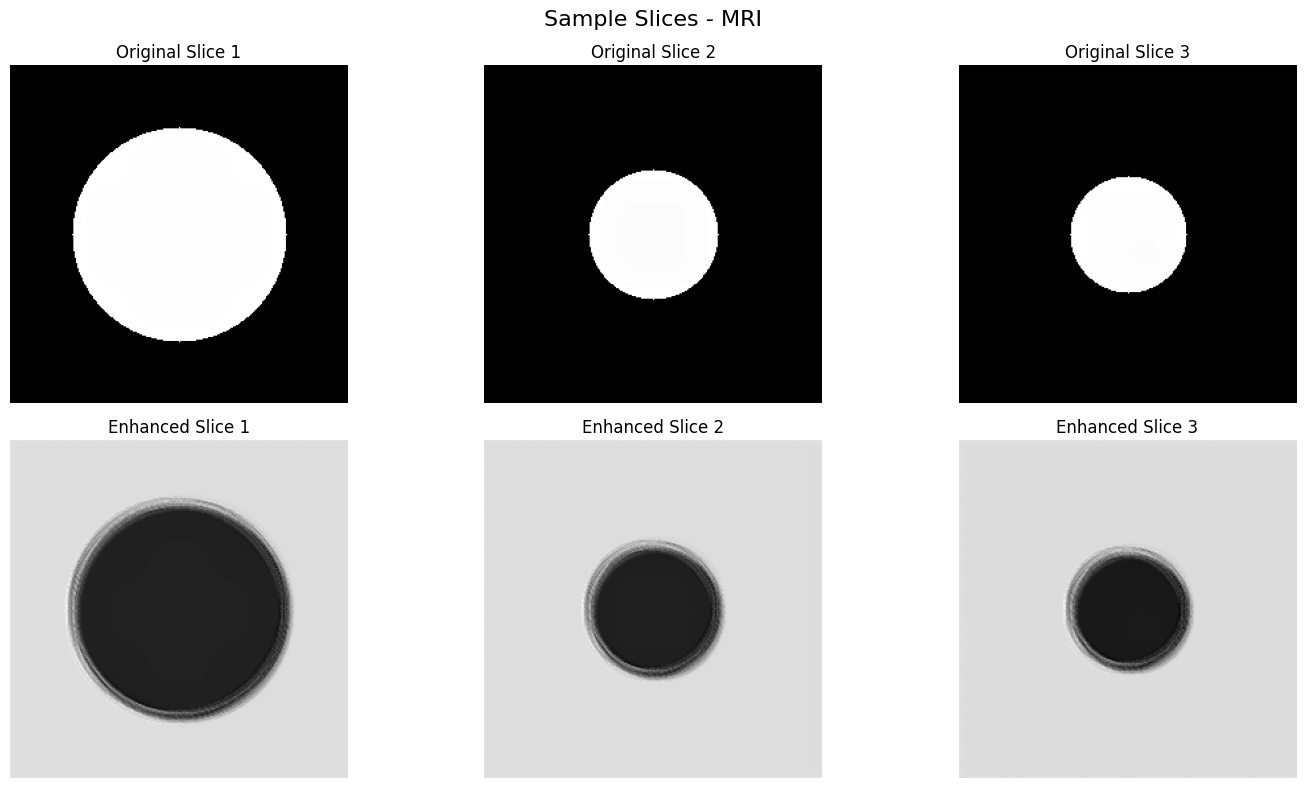

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from scipy.ndimage import uniform_filter, generic_filter
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

def build_srcnn_model():
    input_img = Input(shape=(None, None, 1))
    x = Conv2D(64, (9, 9), padding='same', activation='relu')(input_img)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    output = Conv2D(1, (5, 5), padding='same', activation='linear')(x)
    model = Model(input_img, output)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_classification_model(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def load_and_process_slices(folder_path, num_slices, target_size=(256, 256), enhance=True):
    processed_slices = []
    
    if not os.path.exists(folder_path):
        print(f" Folder path does not exist: {folder_path}")
        return processed_slices
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.dcm'))]
    image_files.sort()  # Ensure consistent order
    
    if len(image_files) == 0:
        print(f" No valid image files found in: {folder_path}")
        return processed_slices
    
    if len(image_files) != num_slices:
        print(f" Number of images in folder ({len(image_files)}) doesn't match metadata num_slices ({num_slices}). Using available images.")
    
    print(f" Loading {len(image_files[:num_slices])} images from {folder_path}...")
    
    for i, image_file in enumerate(tqdm(image_files[:num_slices])):
        try:
            img_path = os.path.join(folder_path, image_file)
            
            if image_file.lower().endswith('.dcm'):
                try:
                    import pydicom
                    ds = pydicom.dcmread(img_path)
                    img = ds.pixel_array
                    img = img.astype(np.float32)
                    img = (img - img.min()) / (img.max() - img.min())
                except ImportError:
                    print(" pydicom not installed. Cannot read DICOM files.")
                    continue
                except Exception as e:
                    print(f" Error reading DICOM file {image_file}: {e}")
                    continue
            else:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    try:
                        pil_img = Image.open(img_path).convert('L')
                        img = np.array(pil_img)
                    except Exception as e:
                        print(f" Failed to load image with both OpenCV and PIL: {img_path}")
                        continue
            
            if img is None:
                print(f" Failed to load image: {img_path}")
                continue
            
            img = cv2.resize(img, target_size)
            
            img = img.astype(np.float32) / 255.0
            
            if enhance:
                img = enhance_contrast(img)
            
            processed_slices.append(img)
            
        except Exception as e:
            print(f" Error processing image {image_file}: {e}")
    
    print(f" Successfully processed {len(processed_slices)} slices from {folder_path}")
    return processed_slices

def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply((image * 255).astype(np.uint8))
    return enhanced.astype(np.float32) / 255.0

def enhance_with_srcnn(slices, srcnn_model):
    print("Enhancing images with SRCNN...")
    enhanced_slices = []
    for slice in tqdm(slices):
        slice_expanded = np.expand_dims(slice, axis=0)
        slice_expanded = np.expand_dims(slice_expanded, axis=-1)
        enhanced = srcnn_model.predict(slice_expanded, verbose=0)
        enhanced = np.squeeze(enhanced)
        enhanced_slices.append(enhanced)
    return enhanced_slices

def calculate_entropy(image):
    image = np.clip(image, 0, 1)
    hist = np.histogram(image, bins=256, range=(0, 1))[0]
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy

def calculate_homogeneity(image):
    try:
        std_dev = generic_filter(image, np.std, size=5)
        homogeneity = 1 / (1 + np.mean(std_dev))
        return homogeneity
    except:
        return 0.5

def calculate_symmetry(image):
    height, width = image.shape
    left_half = image[:, :width//2]
    right_half = image[:, width//2:]
    right_flipped = np.fliplr(right_half)
    if left_half.shape == right_flipped.shape:
        mse = np.mean((left_half - right_flipped) ** 2)
        symmetry = 1 / (1 + mse)
        return symmetry
    return 0.5

def estimate_cardiac_area(image):
    try:
        img_8bit = (image * 255).astype(np.uint8)
        _, thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            return area / (image.shape[0] * image.shape[1])
    except Exception as e:
        print(f" Error estimating cardiac area: {e}")
    return 0

def extract_image_features(slices):
    print(" Extracting image features...")
    features = []
    for i, slice in enumerate(tqdm(slices)):
        try:
            slice_features = {
                'slice_number': i + 1,
                'mean_intensity': np.mean(slice),
                'std_intensity': np.std(slice),
                'max_intensity': np.max(slice),
                'min_intensity': np.min(slice),
                'contrast': np.max(slice) - np.min(slice),
                'entropy': calculate_entropy(slice),
                'homogeneity': calculate_homogeneity(slice),
                'cardiac_area': estimate_cardiac_area(slice),
                'symmetry_score': calculate_symmetry(slice)
            }
            features.append(slice_features)
        except Exception as e:
            print(f" Error extracting features from slice {i+1}: {e}")
            continue
    
    return features

def preprocess_patient_data(patient_data, patient_id):
    results = {}
    
    if patient_data.empty:
        print(f" No data found for patient {patient_id}")
        return results

    print(" Initializing models...")
    srcnn_model = build_srcnn_model()
    classification_model = build_classification_model()

    for _, row in patient_data.iterrows():
        modality = row['Modality']
        folder_path = row['Folder_Path']
        num_slices = row['Num_Slices']
        age = row['Age']
        gender = row['Gender']
        
        print(f"\n Processing {modality} for {patient_id}...")
        print(f" Folder path: {folder_path}")
        print(f" Expected slices: {num_slices}")
        
        slices = load_and_process_slices(folder_path, num_slices, enhance=True)
        
        if len(slices) == 0:
            print(f"❌ No slices loaded for {patient_id} {modality}")
            continue
        
        enhanced_slices = enhance_with_srcnn(slices, srcnn_model)
        
        image_features = extract_image_features(enhanced_slices)
        
        results[modality] = {
            'slices': slices,
            'enhanced_slices': enhanced_slices,
            'image_features': image_features,
            'patient_info': {
                'age': age,
                'gender': gender,
                'modality': modality,
                'num_slices_processed': len(slices)
            }
        }
        
        print(f" Successfully processed {modality}: {len(slices)} slices")
    
    return results

def get_feature_statistics(image_features):
    if not image_features:
        return {}
    
    feature_names = ['mean_intensity', 'std_intensity', 'contrast', 'entropy', 
                    'homogeneity', 'cardiac_area', 'symmetry_score']
    
    stats = {}
    for feature in feature_names:
        values = [f[feature] for f in image_features if feature in f]
        if values:
            stats[feature] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
    
    return stats

def validate_image_slices(slices):
    validation_results = {
        'total_slices': len(slices),
        'valid_slices': 0,
        'quality_scores': [],
        'issues': []
    }
    
    for i, slice in enumerate(slices):
        if slice is None or slice.size == 0:
            validation_results['issues'].append(f"Slice {i+1}: Empty or invalid")
            continue
        
        if slice.shape[0] < 64 or slice.shape[1] < 64:
            validation_results['issues'].append(f"Slice {i+1}: Dimensions too small {slice.shape}")
            continue
        
        if np.all(slice == 0) or np.all(slice == 1):
            validation_results['issues'].append(f"Slice {i+1}: No variation in pixel values")
            continue
        
        quality_score = calculate_image_quality(slice)
        validation_results['quality_scores'].append(quality_score)
        validation_results['valid_slices'] += 1
    
    return validation_results

def calculate_image_quality(image):
    contrast = np.max(image) - np.min(image)
    entropy_val = calculate_entropy(image)
    
    quality = (contrast + entropy_val/10) / 2
    return min(quality, 1.0)  # Cap at 1.0

def display_preprocessing_summary(results):
    print("\n" + "="*60)
    print(" PREPROCESSING SUMMARY")
    print("="*60)
    
    for modality, data in results.items():
        patient_info = data['patient_info']
        image_features = data['image_features']
        
        print(f"\n Modality: {modality}")
        print(f"   Patient: {patient_info['age']} years, {patient_info['gender']}")
        print(f"   Slices processed: {patient_info['num_slices_processed']}")
        print(f"   Features extracted: {len(image_features)}")
        
        stats = get_feature_statistics(image_features)
        if stats:
            print("   Feature Statistics:")
            for feature, stat in stats.items():
                print(f"     {feature}: {stat['mean']:.3f} ± {stat['std']:.3f}")

if __name__ == "__main__":
    print(" Loading dataset...")
    df = pd.read_csv('master_metadata.csv')
    
    print(f" Dataset loaded: {len(df)} records")
    print(f" Available patients: {df['Patient_ID'].unique()}")
    print(f" Available modalities: {df['Modality'].unique()}")
    
    if len(df) > 0:
        sample_patient = df['Patient_ID'].iloc[0]
        print(f"\n🧪 Testing with patient: {sample_patient}")
        
        patient_data = df[df['Patient_ID'] == sample_patient]
        results = preprocess_patient_data(patient_data, sample_patient)
        
        if results:
            display_preprocessing_summary(results)
            
            for modality, data in results.items():
                slices = data['slices']
                enhanced_slices = data['enhanced_slices']
                
                if len(slices) > 0:
                    fig, axes = plt.subplots(2, min(3, len(slices)), figsize=(15, 8))
                    fig.suptitle(f'Sample Slices - {modality}', fontsize=16)
                    
                    for i in range(min(3, len(slices))):
                        axes[0, i].imshow(slices[i], cmap='gray')
                        axes[0, i].set_title(f'Original Slice {i+1}')
                        axes[0, i].axis('off')
                        
                        axes[1, i].imshow(enhanced_slices[i], cmap='gray')
                        axes[1, i].set_title(f'Enhanced Slice {i+1}')
                        axes[1, i].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
        else:
            print("No results obtained from preprocessing")